# Credit Card Fraud

#### Perform exploratory data analysis to identify insights and patterns that can help you build the model.

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [206]:
#Loading in the data from parquet file
cc_transaction= pd.read_parquet('credit_card_transaction_data_de.parquet')
cc_user = pd.read_parquet('credit_card_users_de.parquet')
card_info = pd.read_parquet('sd254_cards_de.parquet')

In [207]:
#removing spaces from column names
cc_transaction.columns = cc_transaction.columns.str.replace(' ', '')
cc_user.columns = cc_user.columns.str.replace(' ', '')
card_info.columns = card_info.columns.str.replace(' ', '')

In [208]:
cc_transaction.head()

,User,Card,Year,Month,Day,Time,Amount,UseChip,MerchantName,MerchantCity,MerchantState,Zip,MCC,Errors?,IsFraud?
4136,0,0,2016,1,3,10:48,$66.48,Chip Transaction,-3345936507911876459,La Verne,CA,91750.0,7538,None,No
4137,0,0,2016,1,4,06:43,$40.02,Chip Transaction,-34551508091458520,La Verne,CA,91750.0,5912,None,No
4138,0,0,2016,1,7,09:30,$54.11,Chip Transaction,4055257078481058705,La Verne,CA,91750.0,7538,None,No
4139,0,0,2016,1,7,16:03,$89.48,Chip Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,None,No
4140,0,0,2016,1,10,06:38,$29.15,Chip Transaction,-5475680618560174533,Monterey Park,CA,91755.0,5942,None,No


In [209]:
card_info.head()


,User,CARDINDEX,CardBrand,CardType,CardNumber,Expires,CVV,HasChip,CardsIssued,CreditLimit,AcctOpenDate,YearPINlastChanged,CardonDarkWeb
0,0,0,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,0,1,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,0,2,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,0,3,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,0,4,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [210]:
cc_user.head()


,Person,CurrentAge,RetirementAge,BirthYear,BirthMonth,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,PerCapitaIncome-Zipcode,YearlyIncome-Person,TotalDebt,FICOScore,NumCreditCards
0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5
1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5
2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,NaN,West Covina,CA,91792,34.02,-117.89,$22681,$33483,$196,698,5
3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,NaN,New York,NY,10069,40.71,-73.99,$163145,$249925,$202328,722,4
4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,NaN,San Francisco,CA,94117,37.76,-122.44,$53797,$109687,$183855,675,1


In [211]:
cc_user.reset_index(inplace=True)
cc_user.rename(columns={'index': 'User'}, inplace=True)

In [212]:
#rename Card into CARDINDEX
card_info.rename(columns={'CARDINDEX': 'Card'}, inplace=True)

In [213]:
cc_transaction_cardinfo.head()

,User,Card,Year,Month,Day,Time,Amount,UseChip,MerchantName,MerchantCity,...,CardType,CardNumber,Expires,CVV,HasChip,CardsIssued,CreditLimit,AcctOpenDate,YearPINlastChanged,CardonDarkWeb
0,0,0,2016,1,3,10:48,$66.48,Chip Transaction,-3345936507911876459,La Verne,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,0,0,2016,1,4,06:43,$40.02,Chip Transaction,-34551508091458520,La Verne,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
2,0,0,2016,1,7,09:30,$54.11,Chip Transaction,4055257078481058705,La Verne,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
3,0,0,2016,1,7,16:03,$89.48,Chip Transaction,3414527459579106770,Monterey Park,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
4,0,0,2016,1,10,06:38,$29.15,Chip Transaction,-5475680618560174533,Monterey Park,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No


In [214]:
cc_transaction_cardinfo= pd.merge(cc_transaction,card_info, on=['User', 'Card'], how='left')

In [215]:
cc_user = cc_user.reset_index().rename_axis('Person')

In [216]:
cc_user.head()

,index,User,Person,CurrentAge,RetirementAge,BirthYear,BirthMonth,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,PerCapitaIncome-Zipcode,YearlyIncome-Person,TotalDebt,FICOScore,NumCreditCards
Person,,,,,,,,,,,,,,,,,,,,
0,0,0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5
1,1,1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5
2,2,2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,NaN,West Covina,CA,91792,34.02,-117.89,$22681,$33483,$196,698,5
3,3,3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,NaN,New York,NY,10069,40.71,-73.99,$163145,$249925,$202328,722,4
4,4,4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,NaN,San Francisco,CA,94117,37.76,-122.44,$53797,$109687,$183855,675,1


In [217]:
cc_transaction_user_card_info = pd.merge(cc_transaction_cardinfo, cc_user, how='left', on='User')


In [218]:
cc_transaction_user_card_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6877837 entries, 0 to 6877836
Data columns (total 45 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   User                     int64  
 1   Card                     int64  
 2   Year                     int64  
 3   Month                    int64  
 4   Day                      int64  
 5   Time                     object 
 6   Amount                   object 
 7   UseChip                  object 
 8   MerchantName             int64  
 9   MerchantCity             object 
 10  MerchantState            object 
 11  Zip                      float64
 12  MCC                      int64  
 13  Errors?                  object 
 14  IsFraud?                 object 
 15  CardBrand                object 
 16  CardType                 object 
 17  CardNumber               int64  
 18  Expires                  object 
 19  CVV                      int64  
 20  HasChip                  object 
 21  CardsIss

In [219]:
# Check for duplicate rows
duplicate_rows = cc_transaction_user_card_info[cc_transaction_user_card_info.duplicated()]

# Display the duplicate rows (if any)
print("Duplicate Rows:")
print(duplicate_rows)

# Count the number of duplicate rows
num_duplicates = len(duplicate_rows)


Duplicate Rows:
         User  Card  Year  Month  Day   Time   Amount            UseChip  \
377956    109     2  2019      3    8  04:22  $120.00   Chip Transaction   
1001139   300     1  2017      8   25  07:15   $63.00   Chip Transaction   
1005374   301     2  2017      6   18  13:21   $80.00  Swipe Transaction   
1128282   332     0  2017      2    7  14:52   $76.00   Chip Transaction   
1194078   356     2  2019     11   16  13:06  $120.00   Chip Transaction   
2652512   803     1  2017      1    1  07:04   $80.00   Chip Transaction   
2653779   803     1  2018     11   28  07:25   $80.00   Chip Transaction   
2655221   803     3  2017      1    8  07:14   $80.00   Chip Transaction   
2656803   803     3  2019      5   31  07:16   $80.00   Chip Transaction   
3578792  1050     2  2016      3   14  13:36   $83.00   Chip Transaction   
3624181  1065     0  2017      9    6  17:53   $80.00   Chip Transaction   
3978721  1160     3  2019      4   16  07:12   $67.00   Chip Transaction

In [220]:
cc_transaction_user_card_info = cc_transaction_user_card_info.drop_duplicates()
print(cc_transaction_user_card_info.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6877821 entries, 0 to 6877836
Data columns (total 45 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   User                     int64  
 1   Card                     int64  
 2   Year                     int64  
 3   Month                    int64  
 4   Day                      int64  
 5   Time                     object 
 6   Amount                   object 
 7   UseChip                  object 
 8   MerchantName             int64  
 9   MerchantCity             object 
 10  MerchantState            object 
 11  Zip                      float64
 12  MCC                      int64  
 13  Errors?                  object 
 14  IsFraud?                 object 
 15  CardBrand                object 
 16  CardType                 object 
 17  CardNumber               int64  
 18  Expires                  object 
 19  CVV                      int64  
 20  HasChip                  object 
 21  CardsIss

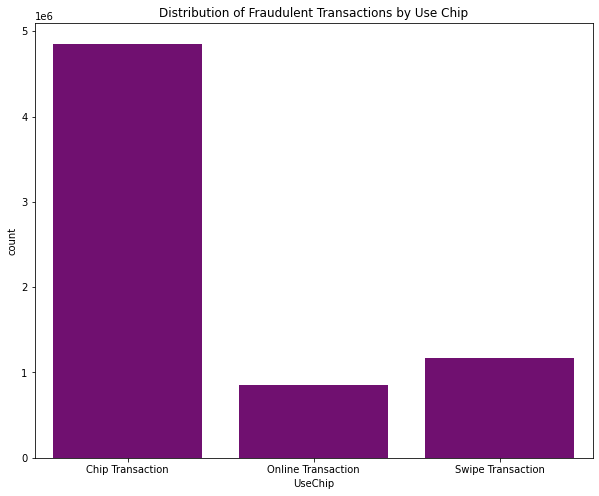

In [221]:


sns.countplot(data=cc_transaction_user_card_info, x='UseChip', color='purple')
plt.title('Distribution of Fraudulent Transactions by Use Chip')
plt.show()

In [222]:

cc_transaction_user_card_info.shape

(6877821, 45)

In [223]:
#How many cases are fraud and how many are not fraud
print(cc_transaction_user_card_info['IsFraud?'].value_counts())
cc_transaction_user_card_info['IsFraud?'].value_counts()/cc_transaction_user_card_info['IsFraud?'].count()*100


No     6869409
Yes       8412
Name: IsFraud?, dtype: int64


No     99.877694
Yes     0.122306
Name: IsFraud?, dtype: float64

##### It looks like about 0.12% of transactions are fraudulent. This is an imbalanced dataset, so we will need to keep this in mind when we build our model.

In [224]:
#Looking for NA values
cc_transaction_user_card_info.isna().sum()

User                             0
Card                             0
Year                             0
Month                            0
Day                              0
Time                             0
Amount                           0
UseChip                          0
MerchantName                     0
MerchantCity                     0
MerchantState               860764
Zip                         907586
MCC                              0
Errors?                    6768762
IsFraud?                         0
CardBrand                        0
CardType                         0
CardNumber                       0
Expires                          0
CVV                              0
HasChip                          0
CardsIssued                      0
CreditLimit                      0
AcctOpenDate                     0
YearPINlastChanged               0
CardonDarkWeb                    0
index                            0
Person                           0
CurrentAge          

#### Understand the dataset and its features to assess data quality and prepare it as needed.

In [225]:
cc_transaction_user_card_info = cc_transaction_user_card_info.drop(columns=["MerchantName","MerchantState","Apartment","Time","Month", "Day", "MerchantCity", "Address", "Latitude", "Longitude", "Expires","AcctOpenDate" ],axis=1)
cc_transaction_user_card_info["Amount"] = cc_transaction_user_card_info["Amount"].str.replace('$','').astype(float)
cc_transaction_user_card_info["IsFraud?"] = cc_transaction_user_card_info["IsFraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

/var/folders/36/bsqg694s1n5fq9vs7qmk_wsw0000gn/T/ipykernel_51279/3680621603.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  cc_transaction_user_card_info["Amount"] = cc_transaction_user_card_info["Amount"].str.replace('$','').astype(float)


In [226]:
#listing all values in the dataset
for col in cc_transaction_user_card_info.columns:
    print(col,':',len(cc_transaction_user_card_info[col].unique()),'labels')

User : 1610 labels
Card : 9 labels
Year : 4 labels
Amount : 63769 labels
UseChip : 3 labels
Zip : 22585 labels
MCC : 109 labels
Errors? : 22 labels
IsFraud? : 2 labels
CardBrand : 4 labels
CardType : 3 labels
CardNumber : 4337 labels
CVV : 991 labels
HasChip : 2 labels
CardsIssued : 3 labels
CreditLimit : 2757 labels
YearPINlastChanged : 19 labels
CardonDarkWeb : 1 labels
index : 1610 labels
Person : 1605 labels
CurrentAge : 80 labels
RetirementAge : 28 labels
BirthYear : 80 labels
BirthMonth : 12 labels
Gender : 2 labels
City : 1089 labels
State : 51 labels
Zipcode : 1490 labels
PerCapitaIncome-Zipcode : 1448 labels
YearlyIncome-Person : 1574 labels
TotalDebt : 1519 labels
FICOScore : 304 labels
NumCreditCards : 9 labels


In [227]:
#Finding my target variable
index_position = cc_transaction_user_card_info.columns.get_loc("IsFraud?")
print(index_position)

8


In [228]:
# Convert Categorical Variables
categorical_columns = ['UseChip', 'Errors?', 'Person', 'Gender', 'City', 'State', 'CardBrand', 'CardType', 'CardonDarkWeb']
label_encoder = LabelEncoder()
cc_transaction_user_card_info[categorical_columns] = cc_transaction_user_card_info[categorical_columns].apply(label_encoder.fit_transform)

# Convert Numeric Columns
numeric_columns = ['PerCapitaIncome-Zipcode', 'YearlyIncome-Person', 'TotalDebt', 'CreditLimit']
cc_transaction_user_card_info[numeric_columns] = cc_transaction_user_card_info[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Handle Boolean Columns
cc_transaction_user_card_info['HasChip'] = cc_transaction_user_card_info['HasChip'].map({'YES': 1, 'NO': 0})
fraud_cases = cc_transaction_user_card_info[cc_transaction_user_card_info['IsFraud?'] == 1]
non_fraud_cases = cc_transaction_user_card_info[cc_transaction_user_card_info['IsFraud?'] == 0]


Confusion Matrix (Entire Dataset):
[[6821254   48155]
 [    487    7925]]

Classification Report (Entire Dataset):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   6869409
           1       0.14      0.94      0.25      8412

    accuracy                           0.99   6877821
   macro avg       0.57      0.97      0.62   6877821
weighted avg       1.00      0.99      1.00   6877821


ROC AUC Score (Entire Dataset):
0.9980301839123404


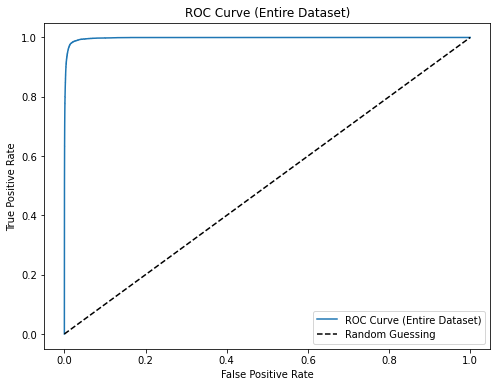

In [229]:

# Undersampling non-fraud cases
non_fraud_sampled = non_fraud_cases.sample(n=10 * len(fraud_cases), random_state=42)

# Combining fraud and sampled non-fraud cases
balanced_df = pd.concat([fraud_cases, non_fraud_sampled])

# Splitting into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    balanced_df.drop('IsFraud?', axis=1), balanced_df['IsFraud?'], test_size=0.2, random_state=42
)

X_balanced = balanced_df.drop('IsFraud?', axis=1)
y_balanced = balanced_df['IsFraud?']

# Create DMatrix for XGBoost
dtrain_balanced = xgb.DMatrix(X_balanced, label=y_balanced)

# Set parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model on the balanced dataset
num_rounds = 100
xgb_model = xgb.train(params, dtrain_balanced, num_rounds)



# Separate features and target variable for the entire dataset
X_full = cc_transaction_user_card_info.drop('IsFraud?', axis=1)
y_full = cc_transaction_user_card_info['IsFraud?']

# Create DMatrix for the entire dataset
dtest_full = xgb.DMatrix(X_full)

# Make predictions on the entire dataset
y_pred_proba_full = xgb_model.predict(dtest_full)

# Convert probabilities to binary predictions (0 or 1)
y_pred_full = [1 if proba >= 0.5 else 0 for proba in y_pred_proba_full]

# Evaluate the model on the entire dataset
print("Confusion Matrix (Entire Dataset):")
print(confusion_matrix(y_full, y_pred_full))
print("\nClassification Report (Entire Dataset):")
print(classification_report(y_full, y_pred_full))
print("\nROC AUC Score (Entire Dataset):")
print(roc_auc_score(y_full, y_pred_proba_full))

# Plot ROC curve for the entire dataset
fpr_full, tpr_full, thresholds_full = roc_curve(y_full, y_pred_proba_full)
plt.figure(figsize=(8, 6))
plt.plot(fpr_full, tpr_full, label='ROC Curve (Entire Dataset)')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Entire Dataset)')
plt.legend()
plt.show()

Interpretation:
Precision (Positive Predictive Value): The precision for predicting fraud (class 1) has improved to 0.14, suggesting a reduction in false positives compared to the previous results.

Recall (Sensitivity, True Positive Rate): The recall remains high at 0.94, indicating that the model is capturing a significant portion of actual fraud cases.

F1-Score: The F1-score for class 1 has improved to 0.25, reflecting a better balance between precision and recall.

Accuracy: The overall accuracy remains high at 0.99, indicating strong performance on the majority class (non-fraud).

ROC AUC Score: The ROC AUC score has improved to 0.9980, reinforcing the model's ability to distinguish between the classes.

Summary:
The model's performance has improved, with a notable increase in precision for class 1 (fraud).
The balance between precision and recall is better, as indicated by the higher F1-score for class 1.
The ROC AUC score remains high, suggesting excellent separation between the classes.

Confusion Matrix:
[[1373777      95]
 [    923     770]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1373872
           1       0.89      0.45      0.60      1693

    accuracy                           1.00   1375565
   macro avg       0.94      0.73      0.80   1375565
weighted avg       1.00      1.00      1.00   1375565


ROC AUC Score:
0.9945998272108356


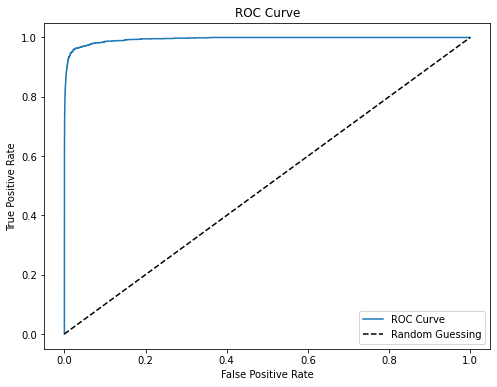

In [230]:
target_column_name = cc_transaction_user_card_info.columns[8]  
X = cc_transaction_user_card_info.drop(target_column_name, axis=1)  
y = cc_transaction_user_card_info[target_column_name] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Make predictions
y_pred_proba = xgb_model.predict(dtest)

# Convert probabilities to binary predictions (0 or 1)
y_pred = [1 if proba >= 0.5 else 0 for proba in y_pred_proba]

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



### Comparison:

1. **Precision for Fraud (Class 1):**
 - **Model 1:** 0.14
 - **Model 2:** 0.89

2. **Recall for Fraud (Class 1):**
 - **Model 1:** 0.94
 - **Model 2:** 0.45

3. **F1-Score for Fraud (Class 1):**
 - **Model 1:** 0.25
 - **Model 2:** 0.60

4. **ROC AUC Score:**
 - **Model 1:** 0.9980
 - **Model 2:** 0.9946

### Summary:

- Model 2 has significantly higher precision for fraud (Class 1), indicating fewer false positives compared to Model 1.
- Model 2, however, has lower recall for fraud, suggesting it may miss more actual fraud cases compared to Model 1.
- The F1-score for fraud is higher in Model 2, indicating a better balance between precision and recall.
- The ROC AUC score is slightly higher in Model 1, indicating better overall separation between the classes.


| True Positive (TP)   | False Positive (FP)  |  

| False Negative (FN)  | True Negative (TN)   |


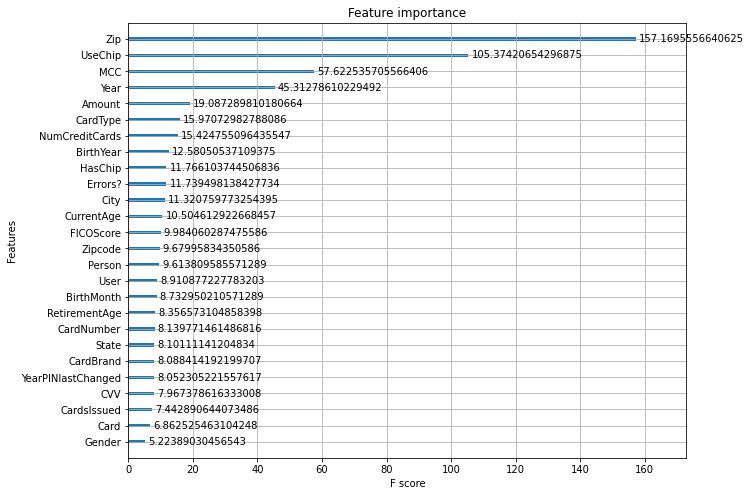

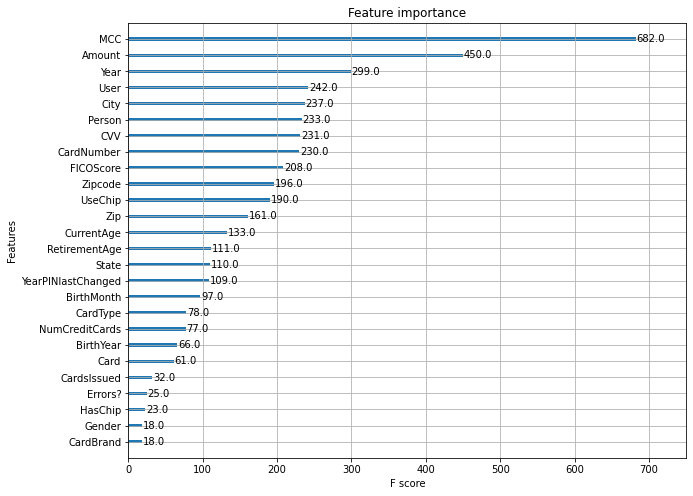

In [232]:
xgb_clf.set_params(reg_alpha=0.01)

# Fit the classifier to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

# Compute the accuracy
accuracy_score(y_test, preds)

# Plot gain instead of weight
xgb.plot_importance(xgb_clf, importance_type="gain")
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8)

# Plot feature importance 
xgb.plot_importance(xgb_clf, importance_type="weight")
matplotlib.rcParams['figure.figsize'] = (10.0, 8)

In [233]:
from sklearn.model_selection import RandomizedSearchCV

# Define a parameter grid
rs_param_grid = {
    # max_depth: values from 3 to 12
    'max_depth': list((range(3,12))),
    # alpha: values 0, .001, .01, .1
    'alpha': [0,0.001, 0.01,0.1,1],
    # subsample: values 0.25,0.5,0.75, 1
    'subsample': [0.5,0.75,1],
    # learning rate: ten values between 0.01 - 0.5
    'learning_rate': np.linspace(0.01,0.5, 10),
    # n_estimators: values 10, 25, 40
    'n_estimators': [10, 25, 40]
    }


# Insantiate XGBoost Clasifier 
xgb_clf = xgb.XGBClassifier(eval_metric='error', random_state=123)

# Instantiate RandomizedSearchCV()
xgb_rs = RandomizedSearchCV(estimator=xgb_clf,param_distributions=rs_param_grid, 
                                cv=3, n_iter=5, verbose=2, random_state=123)

# Train the model on the training set
xgb_rs.fit(X_train, y_train)

# Print the best parameters and highest accuracy
print("Best parameters found: ", xgb_rs.best_params_)
print("Best accuracy found: ", xgb_rs.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END alpha=1, learning_rate=0.22777777777777777, max_depth=5, n_estimators=10, subsample=0.5; total time= 1.2min
[CV] END alpha=1, learning_rate=0.22777777777777777, max_depth=5, n_estimators=10, subsample=0.5; total time= 1.2min
[CV] END alpha=1, learning_rate=0.22777777777777777, max_depth=5, n_estimators=10, subsample=0.5; total time= 1.2min
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=6, n_estimators=40, subsample=1; total time= 4.5min
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=6, n_estimators=40, subsample=1; total time= 4.7min
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=6, n_estimators=40, subsample=1; total time= 4.5min
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=8, n_estimators=40, subsample=0.75; total time= 6.4min
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=8, n_estimators=40, subsample=0.75; total time= 6.5min
[CV] END